### Libraries

In [50]:
# Load Libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from datetime import date, timedelta,datetime
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:0,.1f}'.format 
sns.set_style("white")

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
print( mpl.__version__)

3.5.2


### Workspace

In [52]:
%cd /home/analysis_lake

/home/analysis_lake


### Day Check

In [53]:
from pytz import timezone
from datetime import datetime
today = datetime.now(timezone('Asia/Seoul'))
print(today)

2022-07-20 18:02:52.703317+09:00


In [54]:
# today = date.today()
yesterday = today - timedelta(1)
this_week = today.isocalendar()[1]

print(today.strftime('%Y-%m-%d'))
print(yesterday.strftime('%Y-%m-%d'))
print(this_week)

2022-07-20
2022-07-19
29


### Big Query

In [55]:
project_id = 'kr-co-vcnc-tada'

In [56]:
import pandas as pd
import pydata_google_auth
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
    'https://www.googleapis.com/auth/bigquery'
]

credentials = pydata_google_auth.get_user_credentials(
  SCOPES, auth_local_webserver=True)

In [57]:
query = """ 

SELECT *
FROM tada_bi_mart.daily_okr
WHERE driver_type in ('NXT') AND date_kr < current_date()
ORDER BY 1 

 """
                
df = pd.read_gbq(query=query, project_id=project_id, credentials=credentials, dialect='standard')


In [58]:
df.head()


,date_kr,driver_type,customer_dau_cnt,customer_dpu_cnt,avg_eta_secs,avg_ata_secs,vehicle_active_cnt,driver_active_cnt
0,2021-11-25,NXT,14636,334,543.421203438,499.610315186,52,52
1,2021-11-26,NXT,20913,802,528.168246445,482.503554502,83,83
2,2021-11-27,NXT,15518,704,548.299866131,497.215528782,72,72
3,2021-11-28,NXT,10427,488,527.680076628,479.954022989,57,57
4,2021-11-29,NXT,10252,1028,498.636528029,444.730560579,139,139


In [59]:
df_analysis = df.copy()

In [60]:
df_analysis.isna().sum()

date_kr               0
driver_type           0
customer_dau_cnt      1
customer_dpu_cnt      0
avg_eta_secs          0
avg_ata_secs          0
vehicle_active_cnt    0
driver_active_cnt     0
dtype: int64

In [61]:
df_analysis['date_kr'] = pd.to_datetime(df_analysis['date_kr'],infer_datetime_format=True)

In [62]:
df_analysis= df_analysis.set_index('date_kr')


In [63]:
df_analysis['customer_dpu_cnt']=df_analysis['customer_dpu_cnt'].astype('float')  
df_analysis['vehicle_active_cnt']=df_analysis['vehicle_active_cnt'].astype('float')  

In [64]:
df_analysis.dtypes

driver_type            object
customer_dau_cnt        Int64
customer_dpu_cnt      float64
avg_eta_secs           object
avg_ata_secs           object
vehicle_active_cnt    float64
driver_active_cnt       Int64
dtype: object

### Rolling Statics

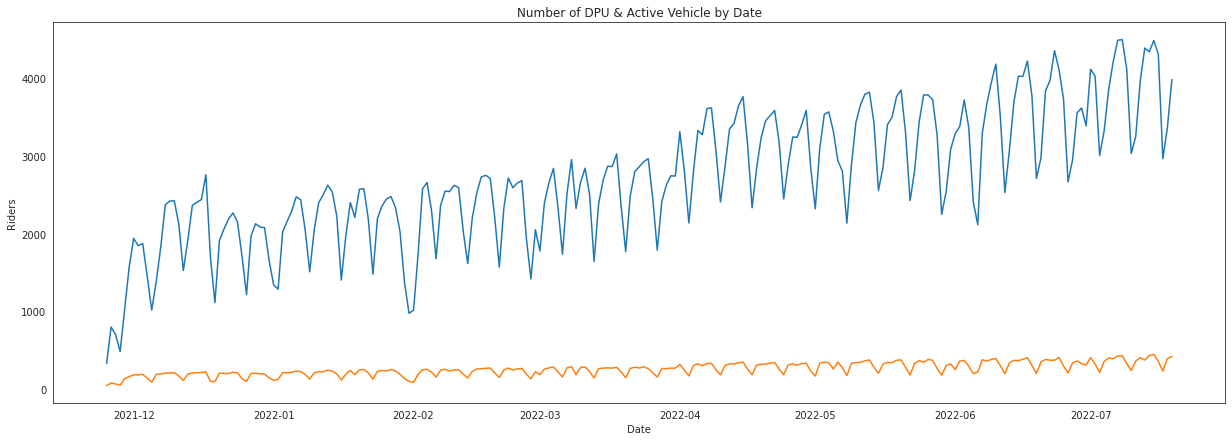

In [65]:

plt.figure(figsize=(21,7))
plt.title("Number of DPU & Active Vehicle by Date")
plt.xlabel('Date')
plt.ylabel('Riders')
plt.plot(df_analysis[['customer_dpu_cnt','vehicle_active_cnt']])
plt.show()

In [66]:
#Determine rolling statistics
df_analysis["rolling_avg"] = df_analysis["customer_dpu_cnt"].rolling(window=7).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df_analysis["rolling_std"] = df_analysis["customer_dpu_cnt"].rolling(window=7).std()

In [67]:
df_analysis

,driver_type,customer_dau_cnt,customer_dpu_cnt,avg_eta_secs,avg_ata_secs,vehicle_active_cnt,driver_active_cnt,rolling_avg,rolling_std
date_kr,,,,,,,,,
2021-11-25,NXT,14636,334.0,543.421203438,499.610315186,52.0,52,NaN,NaN
2021-11-26,NXT,20913,802.0,528.168246445,482.503554502,83.0,83,NaN,NaN
2021-11-27,NXT,15518,704.0,548.299866131,497.215528782,72.0,72,NaN,NaN
2021-11-28,NXT,10427,488.0,527.680076628,479.954022989,57.0,57,NaN,NaN
2021-11-29,NXT,10252,"1,028.0",498.636528029,444.730560579,139.0,139,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-07-15,NXT,19258,"4,476.0",537.970057582,475.743953935,451.0,459,"3,933.4",573.6
2022-07-16,NXT,21266,"4,300.0",528.145564516,465.159072581,361.0,366,"3,960.6",587.6
2022-07-17,NXT,14990,"2,960.0",524.129143845,458.892764485,237.0,237,"3,951.0",605.6


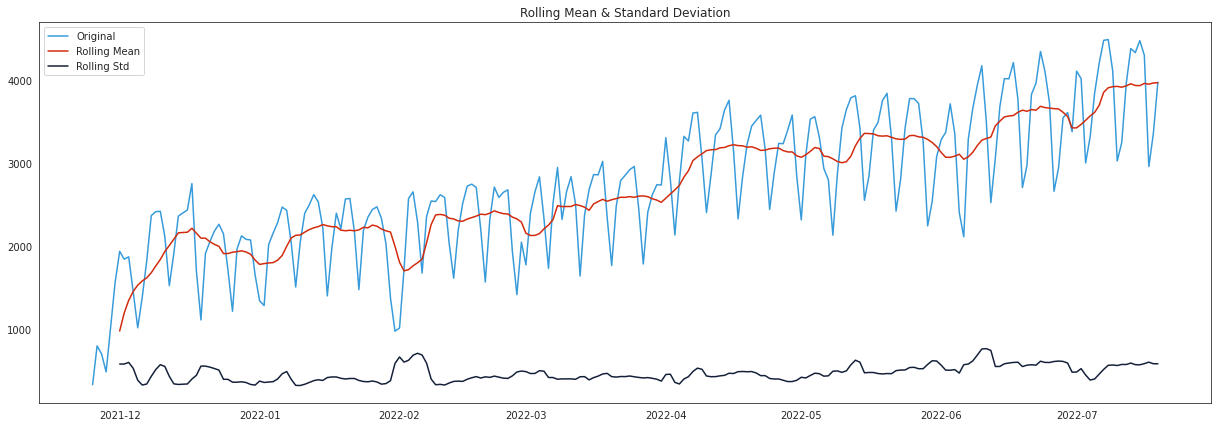

In [68]:
#Plot rolling statistics
plt.figure(figsize=(21,7))
plt.plot(df_analysis["customer_dpu_cnt"], color='#379BDB', label='Original')
plt.plot(df_analysis["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_analysis["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

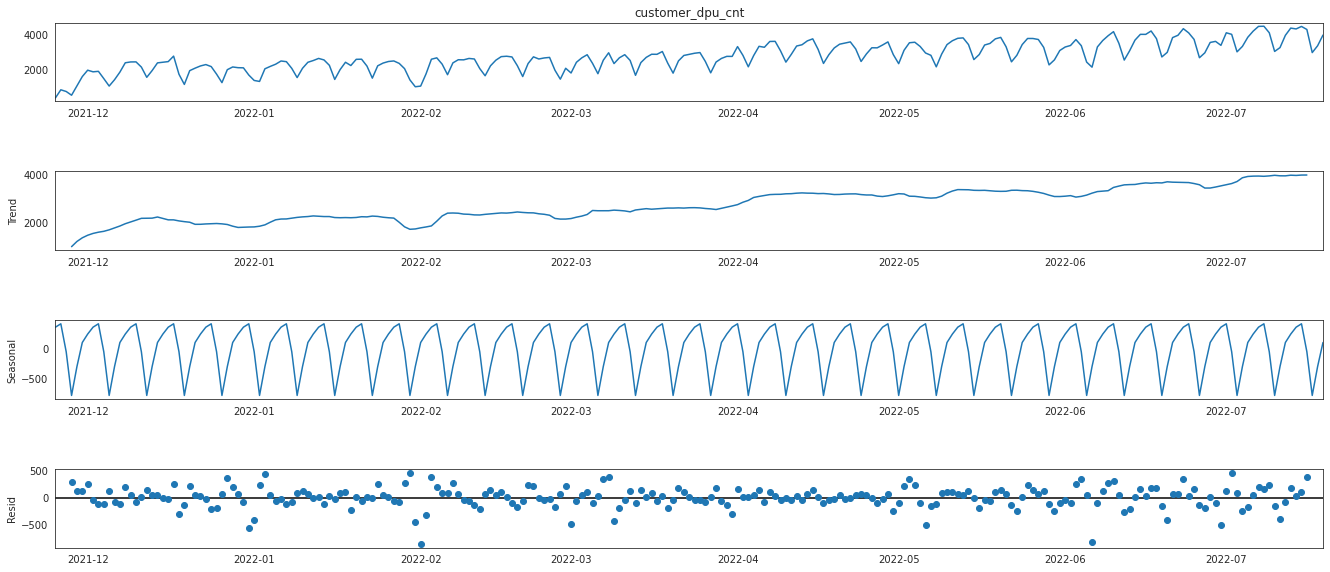

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(df_analysis['customer_dpu_cnt'], model="additive")
fig = decompose_data.plot()
fig.set_size_inches(21, 9)
plt.show();

### Augmented Dickey–Fuller Test

In [70]:
from statsmodels.tsa.stattools import adfuller


* Null Hypothesis: The data is not stationary.
* Alternative Hypothesis: The data is stationary.

In [71]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_analysis['customer_dpu_cnt'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -0.4
p-value                         0.9
#Lags Used                     14.0
Number of Observations Used   222.0
Critical Value (1%)            -3.5
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64


### ARIMA Model

In [72]:
import pmdarima as pm



In [73]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df_analysis['customer_dpu_cnt'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3584.688, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4442.505, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3599.031, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3577.187, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3595.924, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3503.126, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3513.923, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3548.804, Time=0.05 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 0.781 seconds


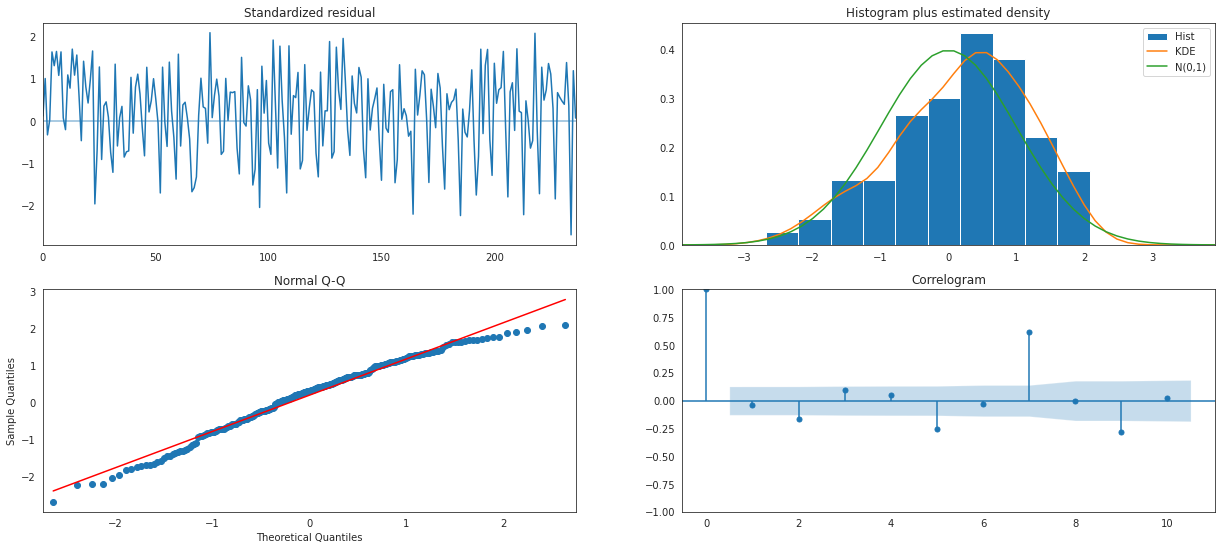

In [74]:
ARIMA_model.plot_diagnostics(figsize=(21,9))
plt.show()


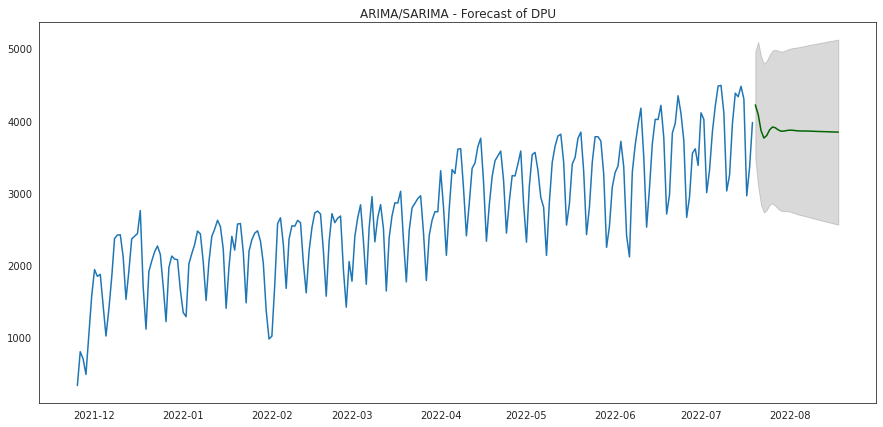

In [75]:

def forecast(ARIMA_model, periods=12):

    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_analysis.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')


    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_analysis["customer_dpu_cnt"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of DPU")

    plt.show()

forecast(ARIMA_model,30)

### SARIMA Model

In [76]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df_analysis["customer_dpu_cnt"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore', 
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=3148.615, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3382.651, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3181.353, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3204.811, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3393.816, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=3256.270, Time=0.07 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=3148.364, Time=0.37 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3181.400, Time=0.67 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3149.936, Time=1.54 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=3148.630, Time=0.80 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3167.454, Time=0.93 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=3206.425, Time=0.26 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=3

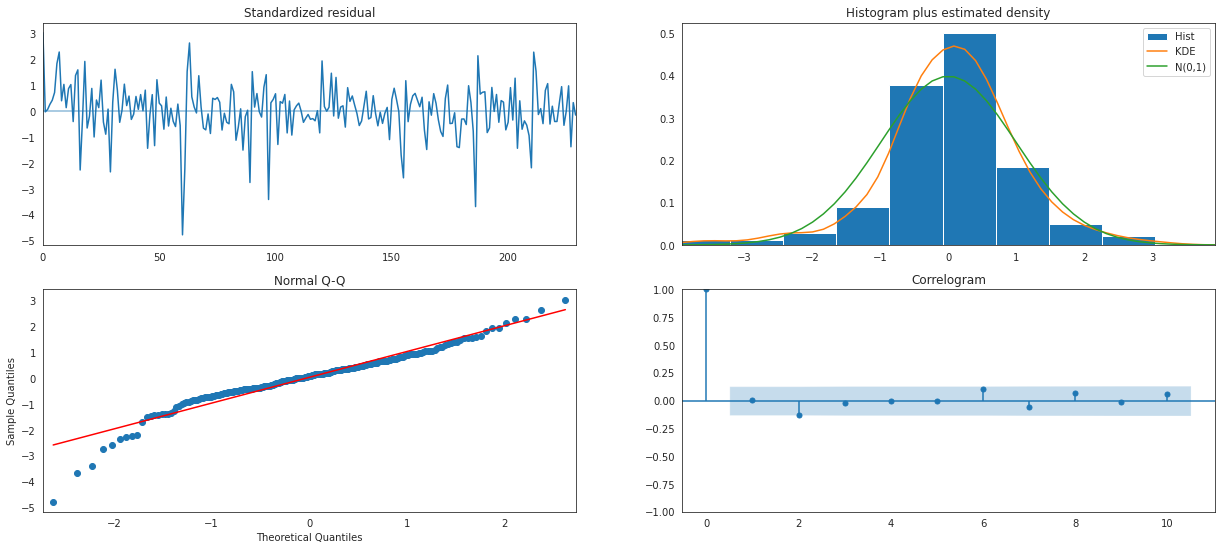

In [77]:
SARIMA_model.plot_diagnostics(figsize=(21,9))
plt.show()


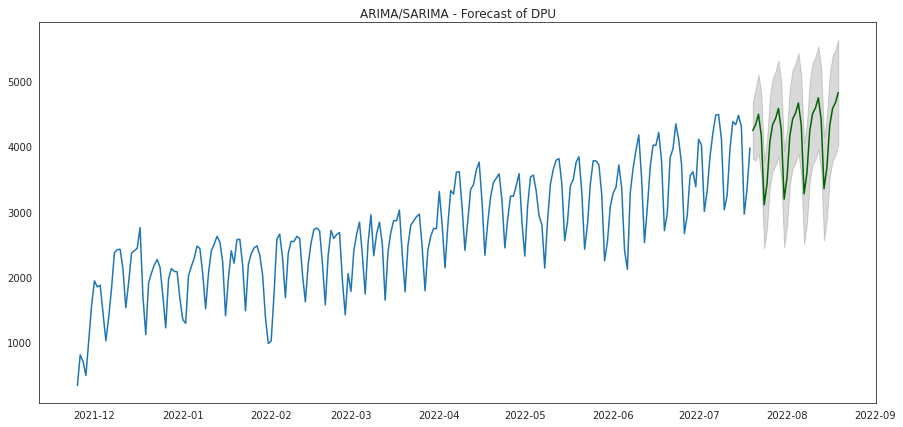

In [78]:

forecast(SARIMA_model,31)



### SARIMAX Model

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [84]:
SARIMAX_model = pm.auto_arima(df_analysis[['customer_dpu_cnt']], exogenous = df_analysis[['vehicle_active_cnt']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=2975.043, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3078.664, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3007.740, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3004.608, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3078.740, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=3049.240, Time=0.12 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=2976.949, Time=0.38 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=2976.950, Time=0.64 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=3004.692, Time=0.20 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=2980.609, Time=0.21 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=2976.438, Time=0.40 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=2976.335, Time=0.55 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=3024.234, Time=0.13 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : 

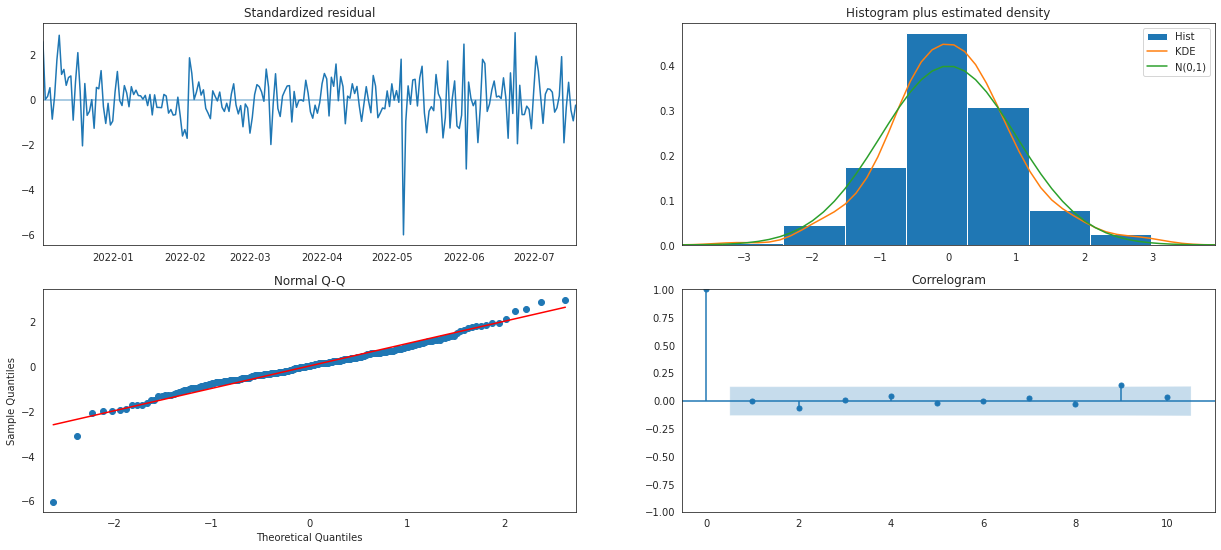

In [85]:
SARIMAX_model.plot_diagnostics(figsize=(21,9))
plt.show()

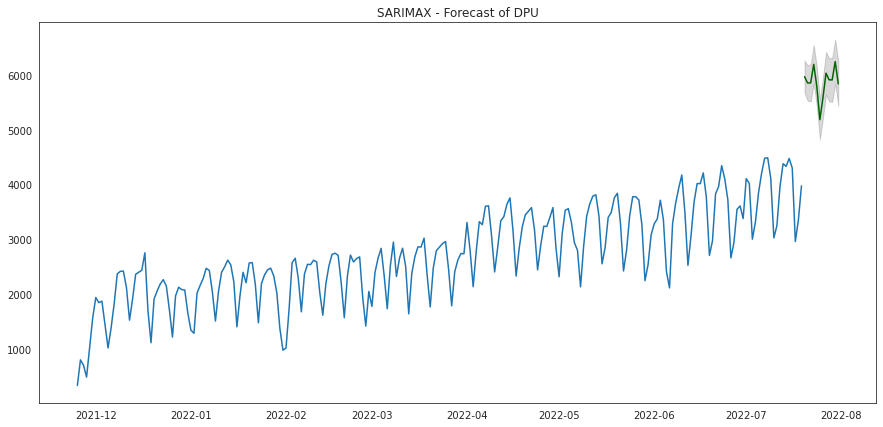

In [92]:
def sarimax_forecast(SARIMAX_model, periods=12):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"vehicle_active_cnt":df_analysis['vehicle_active_cnt'].max()+200},
                    index = pd.date_range(df_analysis.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['vehicle_active_cnt']])
    index_of_fc = pd.date_range(df_analysis.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_analysis["customer_dpu_cnt"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of DPU")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=12)

In [86]:
df_analysis['vehicle_active_cnt'].max()

451.0

### SARIMA Model_Vehicle

In [94]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_analysis['vehicle_active_cnt'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -0.2
p-value                         0.9
#Lags Used                     14.0
Number of Observations Used   222.0
Critical Value (1%)            -3.5
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64


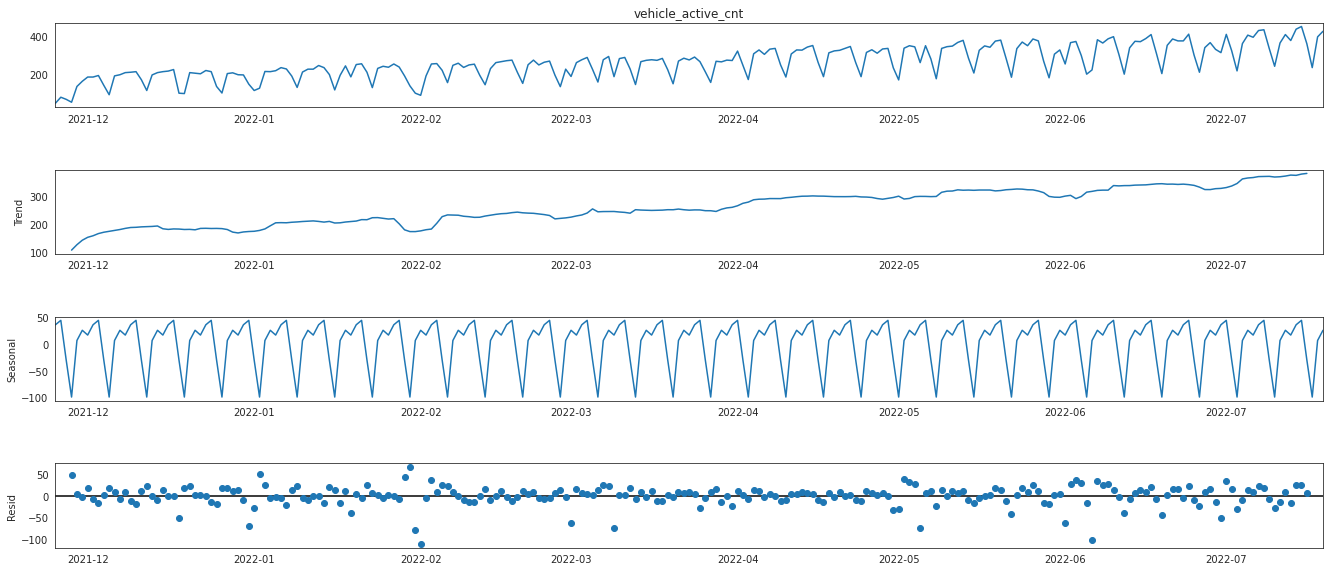

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(df_analysis['vehicle_active_cnt'], model="additive")
fig = decompose_data.plot()
fig.set_size_inches(21, 9)
plt.show();

In [95]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df_analysis["vehicle_active_cnt"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=7, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore', 
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=2176.357, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2322.463, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=2219.503, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=2182.226, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2331.769, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=2280.453, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=2178.272, Time=0.26 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=2178.273, Time=0.28 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=2221.255, Time=0.15 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=2179.583, Time=0.53 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=2174.387, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=2278.466, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=2176.313, Time=0.13 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=2176.314, Time=0.18 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept

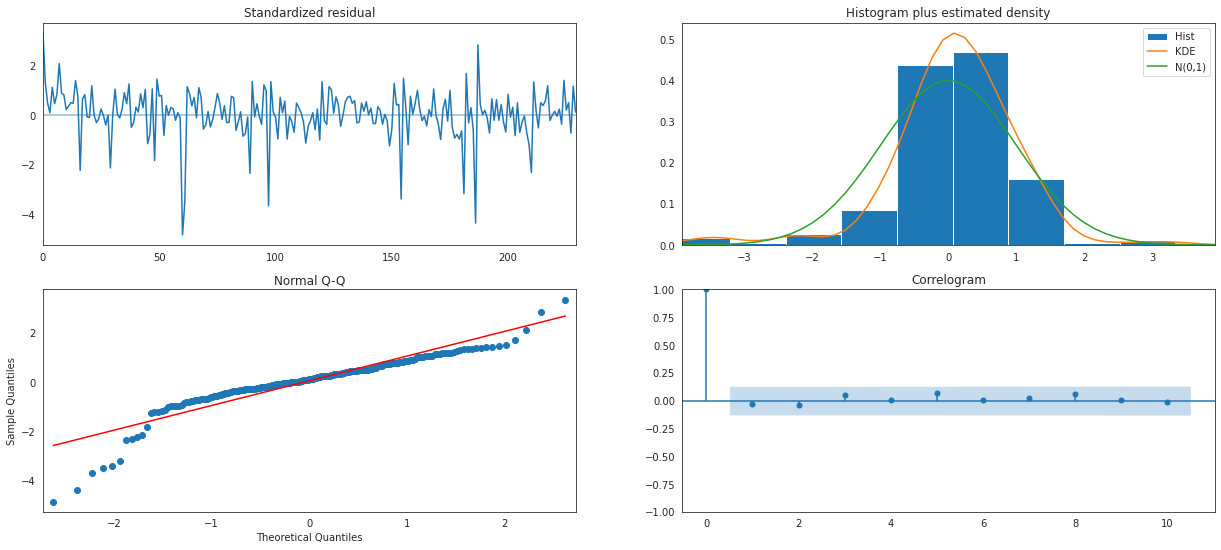

In [96]:
SARIMA_model.plot_diagnostics(figsize=(21,9))
plt.show();

In [97]:
 fitted, confint = SARIMA_model.predict(n_periods=7, return_conf_int=True)

In [100]:
pd.Series(fitted)

0   397.6
1   419.7
2   441.8
3   349.3
4   250.6
5   381.9
6   419.6
dtype: float64

In [108]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  237
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1083.193
Date:                             Wed, 20 Jul 2022   AIC                           2174.387
Time:                                     09:38:18   BIC                           2188.139
Sample:                                          0   HQIC                          2179.934
                                             - 237                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5375      0.470      7.526      0.000       2.616       4.459
ar.L1          0.4794      0.037     12.827      0.000       0.406       0.553
ma.S.L7       -0.8144      0.067    -12.137      0.000      -0.946      -0.683
sigma2       697.0716     43.783     15.921      0.000     611.259     782.884
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               383.26
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -1.44
Prob(H) (two-sided):                  0.63   Kurtosis:                         8.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
df_analysis.tail()

,driver_type,customer_dau_cnt,customer_dpu_cnt,avg_eta_secs,avg_ata_secs,vehicle_active_cnt,driver_active_cnt,rolling_avg,rolling_std
date_kr,,,,,,,,,
2022-07-15,NXT,19258,"4,476.0",537.970057582,475.743953935,451.0,459,"3,933.4",573.6
2022-07-16,NXT,21266,"4,300.0",528.145564516,465.159072581,361.0,366,"3,960.6",587.6
2022-07-17,NXT,14990,"2,960.0",524.129143845,458.892764485,237.0,237,"3,951.0",605.6
2022-07-18,NXT,15760,"3,355.0",526.857640617,464.733200597,397.0,402,"3,966.1",586.2
2022-07-19,NXT,<NA>,"3,975.0",505.743316625,439.995822891,426.0,431,"3,968.1",586.2
